# Lane Detection

## Setup

### Dependencies

In [1]:
# %pip install --upgrade pip --quiet
# %pip install numpy open3d opencv-python seaborn rospkg cachetools numpy-quaternion rosbag pycryptodome scikit-learn --quiet

### Imports

In [14]:
import numpy as np
import open3d as o3d
import quaternion
import cv2 as cv
import rosbag

import matplotlib.pyplot as plt

from dataclasses import dataclass
from datetime import datetime, timedelta

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Import current package

In [15]:
import sys
sys.path.append("../src/")

In [16]:
%load_ext autoreload
%autoreload 2

In [17]:
from kal2_perception.birds_eye_view import BevRoi, BevTransformer

### Load sample images from rosbag

In [6]:
@dataclass
class ImageStamped:
    image: np.ndarray
    timestamp: datetime

In [7]:
def datetime_from_ros_timestamp(secs, nsecs):
    return datetime.fromtimestamp(secs) + timedelta(microseconds=nsecs / 1000)

In [8]:
def extract_images_with_timestamp(bag: str, topic: str, trim_front: float, trim_back: float, n=10):
    from cv_bridge import CvBridge

    bridge = CvBridge()

    images = []

    with rosbag.Bag(bag) as bag:
        start_time = datetime.fromtimestamp(bag.get_start_time())
        end_time = datetime.fromtimestamp(bag.get_end_time())
        sample_interval = (end_time - start_time - timedelta(seconds=trim_front + trim_back)) / n
        last_timestamp = None

        for index, (topic, msg, _) in enumerate(bag.read_messages(topics=[topic])):
            timestamp = datetime_from_ros_timestamp(msg.header.stamp.secs, msg.header.stamp.nsecs)

            if timestamp < start_time + timedelta(seconds=trim_front):
                continue

            if timestamp > end_time - timedelta(seconds=trim_back):
                break

            if last_timestamp is None or timestamp > last_timestamp + sample_interval:
                encoding = "bgr8" if msg.encoding == "rgb8" else "16UC1"
                timestamp = datetime_from_ros_timestamp(msg.header.stamp.secs, msg.header.stamp.nsecs)

                cv_image = bridge.imgmsg_to_cv2(msg, encoding)

                if msg.encoding == "rgb8":
                    cv_image = cv.cvtColor(cv_image, cv.COLOR_RGB2BGR)
                images.append(ImageStamped(image=cv_image, timestamp=timestamp))

                last_timestamp = timestamp

    return np.array(images)

In [81]:
BAG_FILE = "/home/josua/2024-04-26-14-10-52.bag"
color_images = extract_images_with_timestamp(BAG_FILE, topic="/camera_front/color/image_raw", trim_front=5, trim_back=5, n=16)
depth_images = extract_images_with_timestamp(BAG_FILE, topic="/camera_front/aligned_depth_to_color/image_raw", trim_front=5, trim_back=5, n=16)

In [10]:
# for img in color_images:
#     cv.imwrite("images/" + img.timestamp.strftime("%Y-%m-%d-%H-%M-%S-%f") + ".png", img.image)
#     print(img.timestamp)

## Preprocessing

In [11]:
def plot_image_grid(images, image_transform=None, figsize=(16, 8)):
    fig, axes = plt.subplots(4, 4, figsize=figsize)

    for i, image in enumerate(images):
        ax = axes[i // 4, i % 4]

        if isinstance(image, ImageStamped):
            image = image.image

        img = image if image_transform is None else image_transform(image)

        ax.imshow(img)
        ax.axis("off")

    return fig

In [12]:
extrinsic_matrix = np.array(
    [
        [-0.00471339, -0.99997761, -0.00474976, 0.00151022],
        [-0.16772034, 0.00547306, -0.98581942, 0.158225],
        [0.98582335, -0.00384992, -0.16774238, -0.21260152],
        [0.0, 0.0, 0.0, 1.0],
    ]
)

intrinsic_matrix = np.array([[913.75, 0.0, 655.42], [0.0, 911.92, 350.49], [0.0, 0.0, 1.0]])

bev_transformer = BevTransformer.from_roi(
        roi=BevRoi(0.5, 3, 1.5), intrinsic_matrix=intrinsic_matrix, extrinsic_matrix=extrinsic_matrix, scale=240
    )

### Sample images

There are 16 sample images, which are approximately equally spaced in time.

Immediately, there are a few things to investigate:
- Is it possible to increase the shutter speed to reduce motion blur?
- Auto exposure settings
- Lens distortion

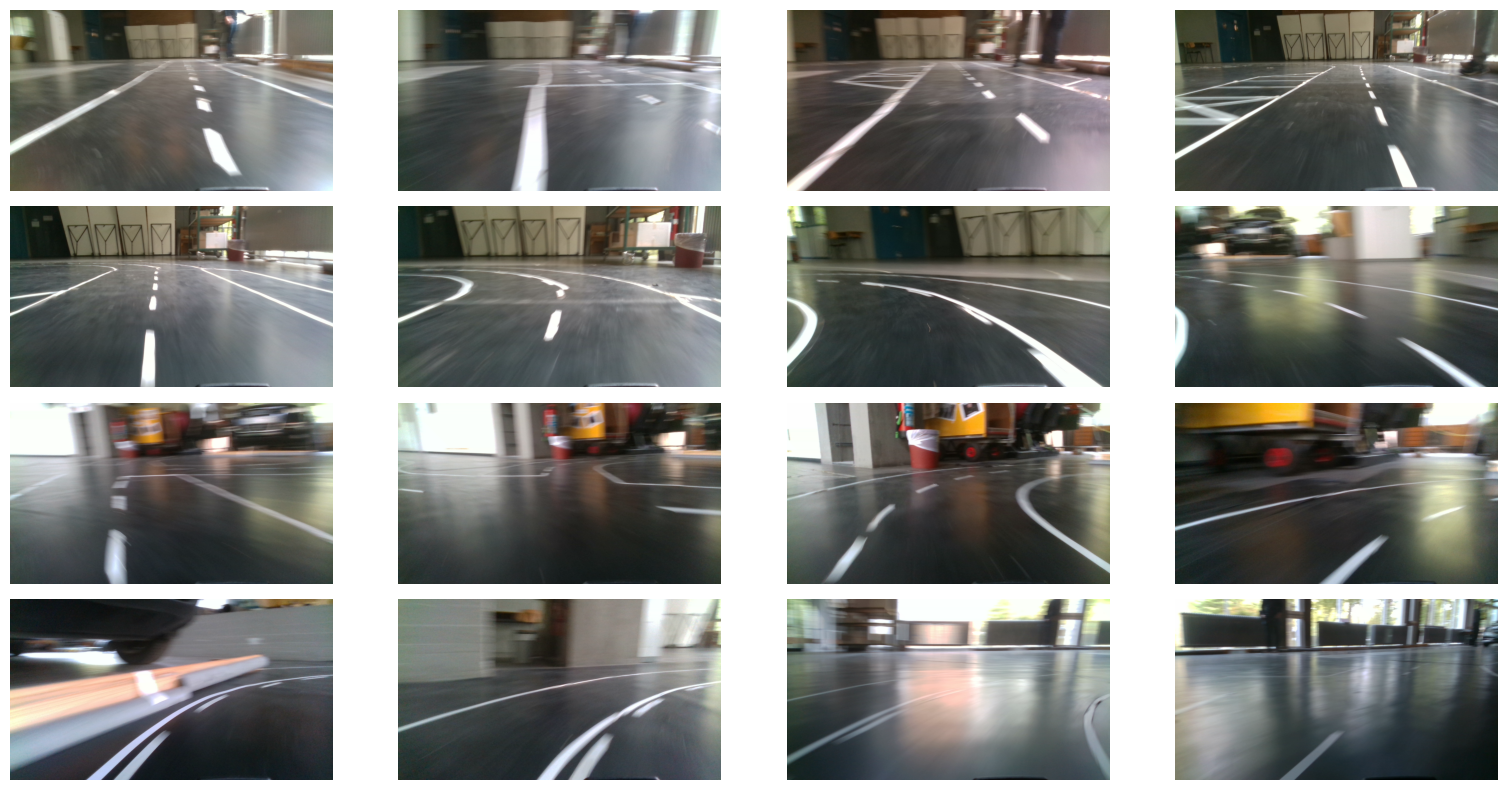

In [13]:
fig = plot_image_grid(color_images)
fig.tight_layout()

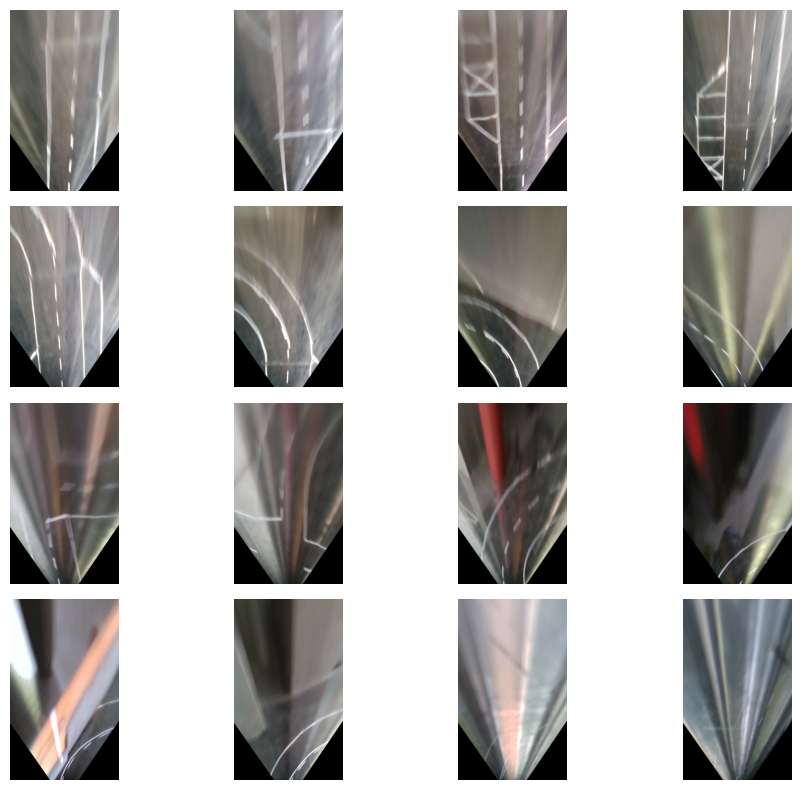

In [14]:
def apply_bev_transform(image):
    return bev_transformer.transform(image)

fig = plot_image_grid(color_images, image_transform=apply_bev_transform, figsize=(10, 8))
fig.tight_layout()

- Perception range is about 2-3m depending on the curvature of the road ahead.
- Reflections are more pronounced in the BEV.

### Canny edge

This filter can be applied before and after the BEV transform.

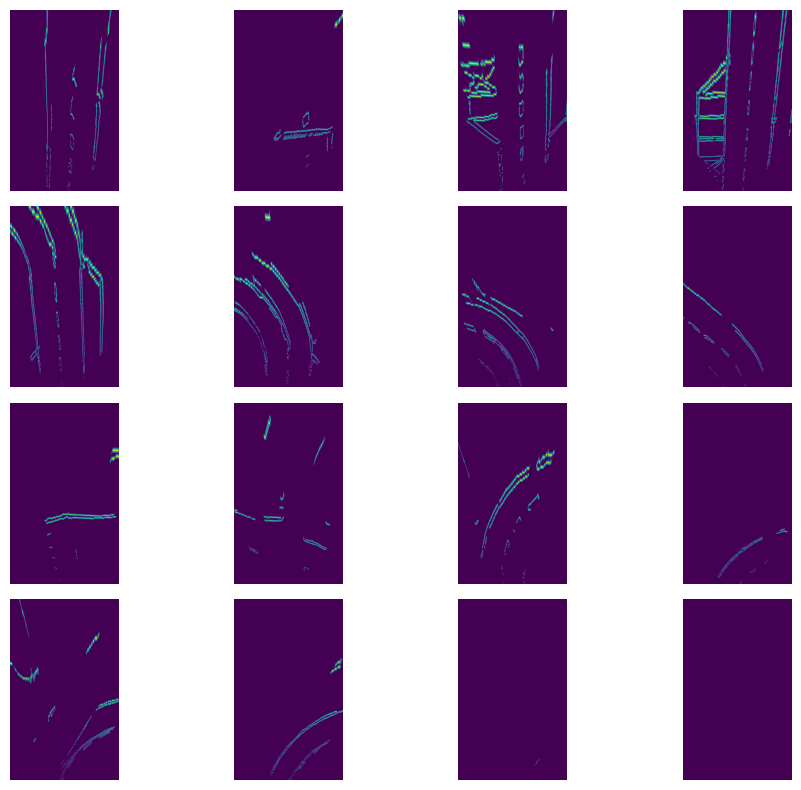

In [15]:
def apply_canny_edge_detection(image):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    edges = cv.Canny(gray, threshold1=100, threshold2=200)
    return bev_transformer.transform(edges)

fig = plot_image_grid(color_images, image_transform=apply_canny_edge_detection, figsize=(10, 8))
fig.tight_layout()

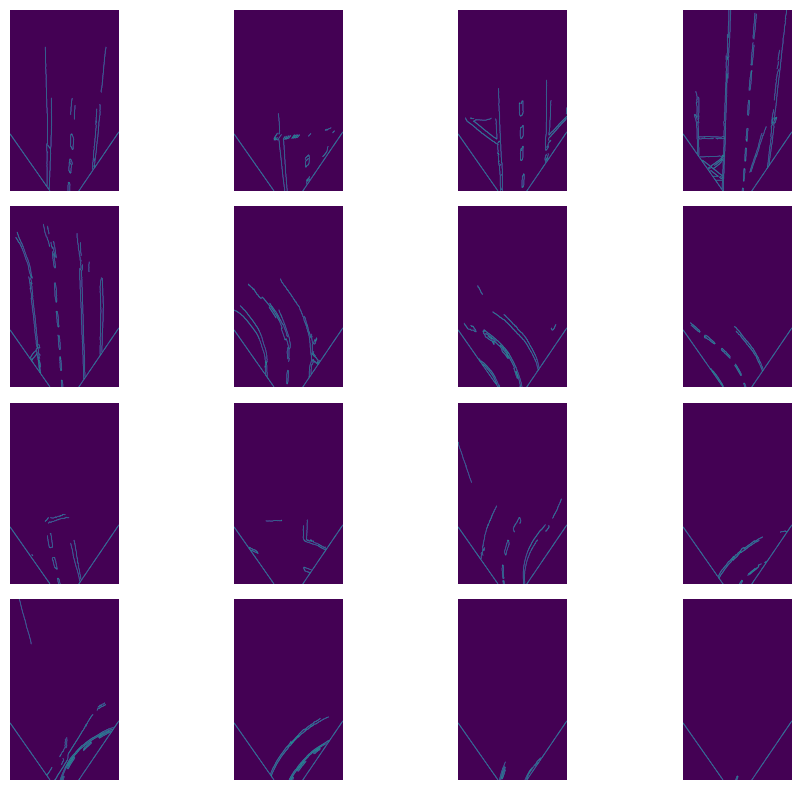

In [16]:
def apply_canny_edge_detection(image):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    gray = bev_transformer.transform(gray)
    edges = cv.Canny(gray, threshold1=100, threshold2=200)
    return edges

fig = plot_image_grid(color_images, image_transform=apply_canny_edge_detection, figsize=(10, 8))
fig.tight_layout()

### Gabor Filter

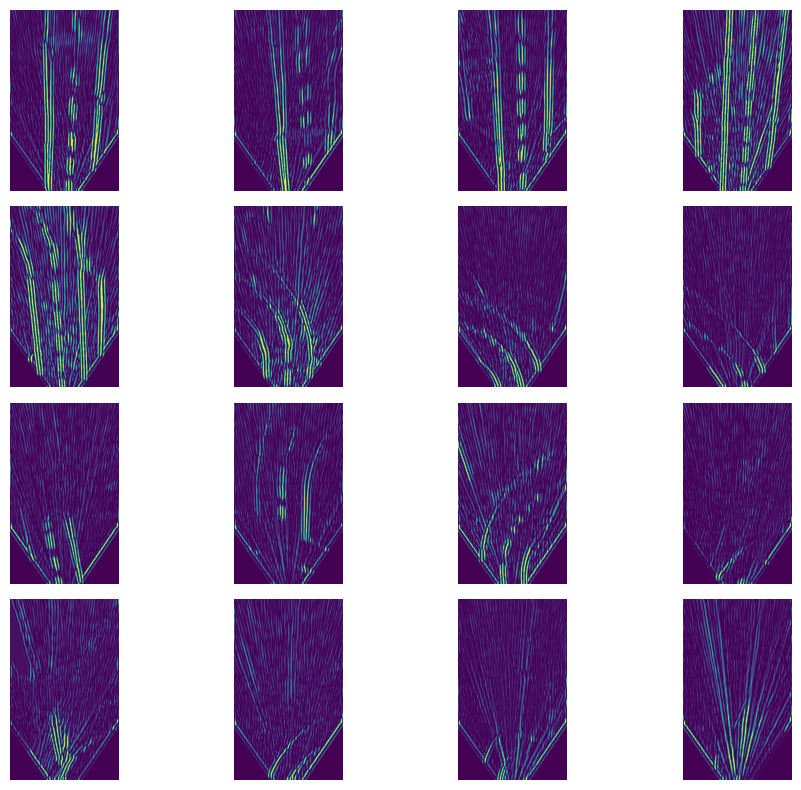

In [17]:
def apply_gabor_filter(image):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    gray = bev_transformer.transform(gray)
    kernel = cv.getGaborKernel(ksize=(32, 32), sigma=5, theta=0, lambd=8, gamma=1, psi=0, ktype=cv.CV_32F)
    filtered = cv.filter2D(gray, cv.CV_8UC3, kernel)
    return filtered

fig = plot_image_grid(color_images, image_transform=apply_gabor_filter, figsize=(10, 8))
fig.tight_layout()

### Matched Filter

In [18]:
def line_kernel(width: int, rows: int):
    kernel = np.ones((rows, width * 3)) * 2
    kernel[:, :width] = -1
    kernel[:, -width:] = -1
    kernel /= np.sum(np.abs(kernel))

    return kernel

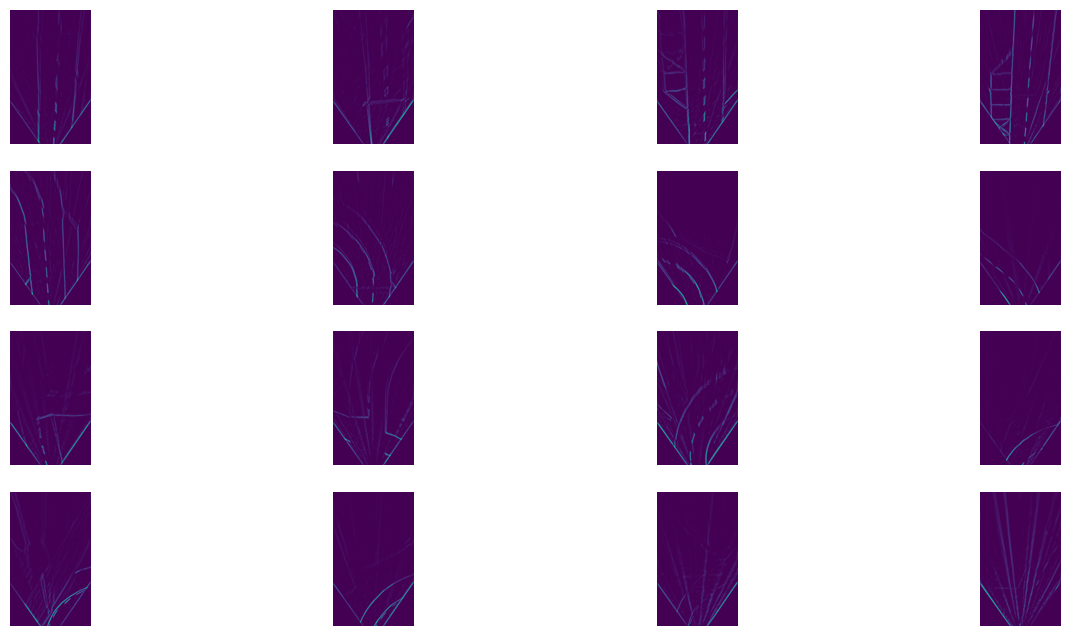

In [19]:
def apply_custom_kernel(image, width=5, rows=3):
    if len(image.shape) == 3:
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    else:
        gray = image

    gray = bev_transformer.transform(gray)
    filtered1 = cv.filter2D(gray, -1, line_kernel(width, rows))
    filtered2 = cv.filter2D(gray, -1, line_kernel(width, rows).T)
    # filtered1[filtered1 < 0.0] = 0
    # filtered2[filtered2 < 0.0] = 0
    filtered = filtered1 + filtered2
    #filtered[filtered < 0.0] = 0
    filtered = (filtered - filtered.min()) / (filtered.max() - filtered.min())
    #filtered[filtered < 0.25] = 0

    return filtered

fig = plot_image_grid(color_images, apply_custom_kernel)

## RGB-D images

In [20]:
def create_rgbd_images(color_images, depth_images):
    rgbd_images = []

    for color_image in color_images:
        timestamp = color_image.timestamp

        try:
            depth_image = next(depth_image for depth_image in depth_images if depth_image.timestamp == timestamp)
        except StopIteration:
            continue

        color_image = o3d.geometry.Image(color_image.image)
        depth_image = o3d.geometry.Image(depth_image.image)
        rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
            color_image, depth_image, depth_scale=1000.0, depth_trunc=20, convert_rgb_to_intensity=False
        )
        rgbd_images.append(rgbd_image)
    return rgbd_images

In [21]:
rgbd_images = create_rgbd_images(color_images, depth_images)

### Sample RGB-D images

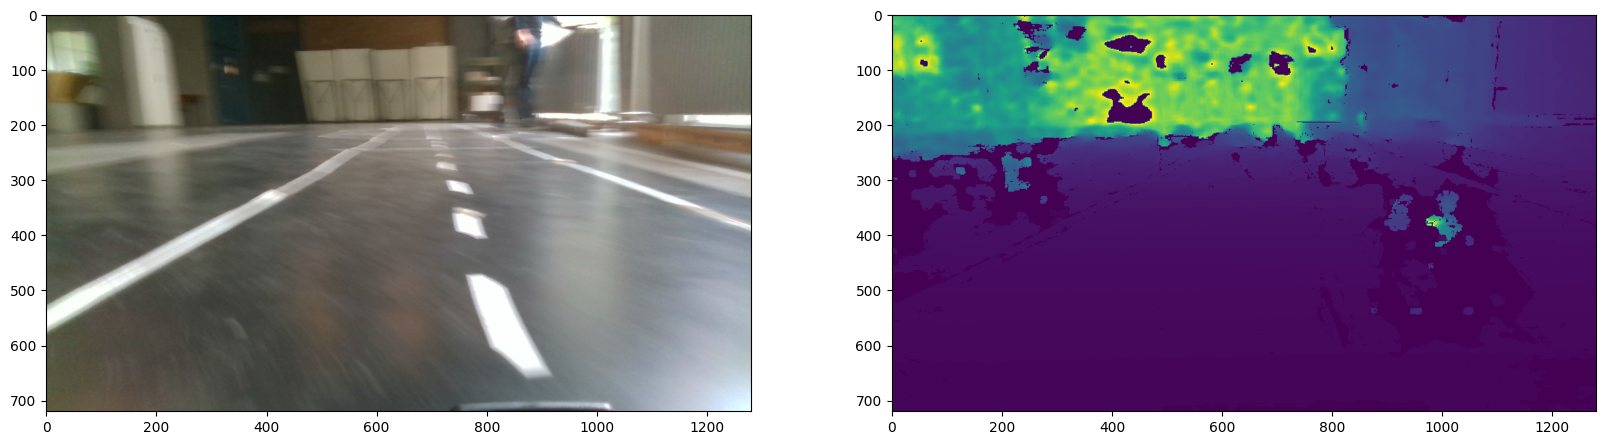

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(rgbd_images[0].color, cmap="gray")
ax[1].imshow(rgbd_images[0].depth);

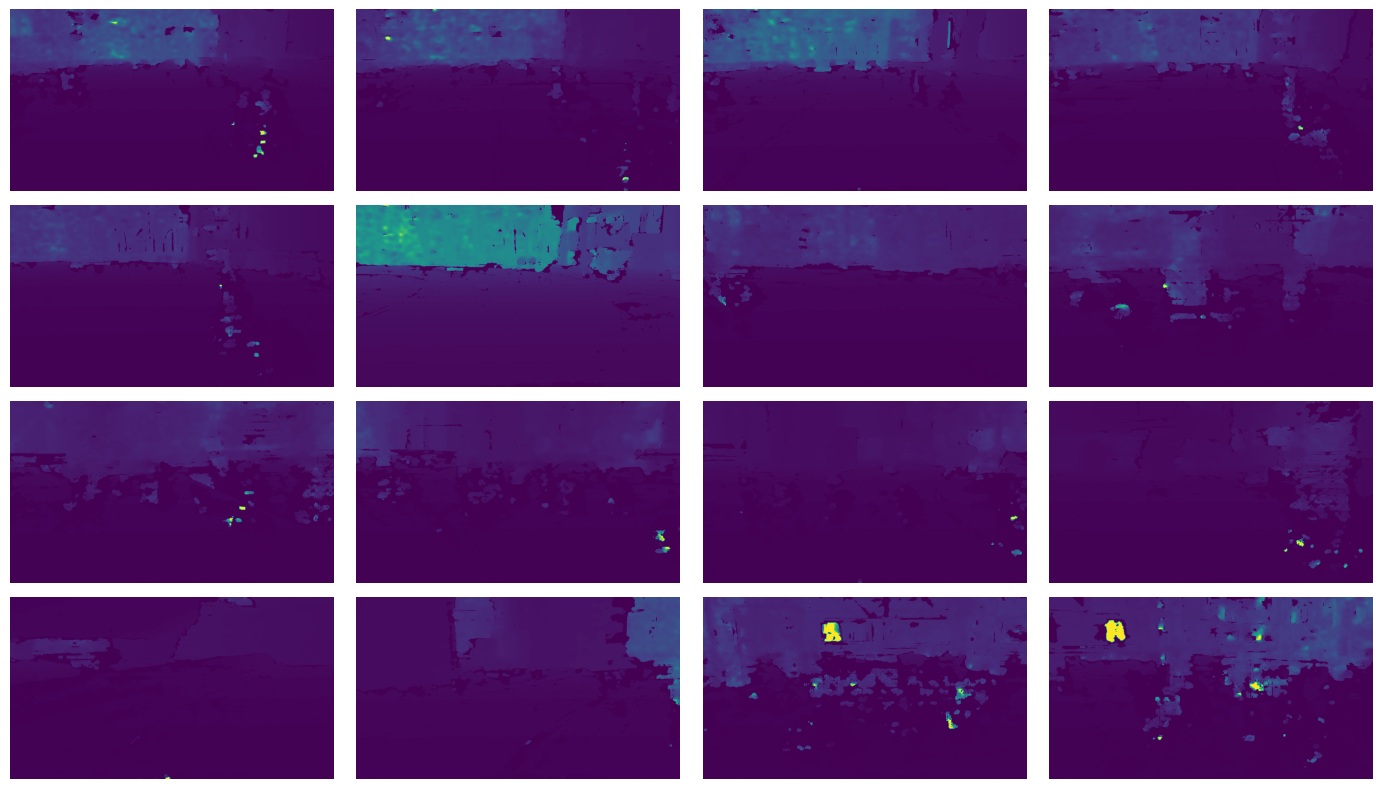

In [23]:
fig = plot_image_grid(depth_images, figsize=(14, 8))
fig.tight_layout()

### Depth completion

Code from [Image Processing for Basic Depth Completion (IP-Basic)](https://github.com/kujason/ip_basic/tree/master).

In [24]:
# Full kernels
FULL_KERNEL_3 = np.ones((3, 3), np.uint8)
FULL_KERNEL_5 = np.ones((5, 5), np.uint8)
FULL_KERNEL_7 = np.ones((7, 7), np.uint8)
FULL_KERNEL_9 = np.ones((9, 9), np.uint8)
FULL_KERNEL_31 = np.ones((31, 31), np.uint8)

# 3x3 cross kernel
CROSS_KERNEL_3 = np.asarray(
    [
        [0, 1, 0],
        [1, 1, 1],
        [0, 1, 0],
    ],
    dtype=np.uint8,
)

# 5x5 cross kernel
CROSS_KERNEL_5 = np.asarray(
    [
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
    ],
    dtype=np.uint8,
)

# 5x5 diamond kernel
DIAMOND_KERNEL_5 = np.array(
    [
        [0, 0, 1, 0, 0],
        [0, 1, 1, 1, 0],
        [1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0],
        [0, 0, 1, 0, 0],
    ],
    dtype=np.uint8,
)

# 7x7 cross kernel
CROSS_KERNEL_7 = np.asarray(
    [
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
    ],
    dtype=np.uint8,
)

# 7x7 diamond kernel
DIAMOND_KERNEL_7 = np.asarray(
    [
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0],
        [0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
    ],
    dtype=np.uint8,
)


def fill_in_fast(depth_map, max_depth=100.0, custom_kernel=DIAMOND_KERNEL_5, extrapolate=False, blur_type="bilateral"):
    """Fast, in-place depth completion.

    Args:
        depth_map: projected depths
        max_depth: max depth value for inversion
        custom_kernel: kernel to apply initial dilation
        extrapolate: whether to extrapolate by extending depths to top of
            the frame, and applying a 31x31 full kernel dilation
        blur_type:
            'bilateral' - preserves local structure (recommended)
            'gaussian' - provides lower RMSE

    Returns:
        depth_map: dense depth map
    """

    # Invert
    valid_pixels = depth_map > 0.1
    depth_map[valid_pixels] = max_depth - depth_map[valid_pixels]

    # Dilate
    depth_map = cv.dilate(depth_map, custom_kernel)

    # Hole closing
    depth_map = cv.morphologyEx(depth_map, cv.MORPH_CLOSE, FULL_KERNEL_5)

    # Fill empty spaces with dilated values
    empty_pixels = depth_map < 0.1
    dilated = cv.dilate(depth_map, FULL_KERNEL_7)
    depth_map[empty_pixels] = dilated[empty_pixels]

    # Extend highest pixel to top of image
    if extrapolate:
        top_row_pixels = np.argmax(depth_map > 0.1, axis=0)
        top_pixel_values = depth_map[top_row_pixels, range(depth_map.shape[1])]

        for pixel_col_idx in range(depth_map.shape[1]):
            depth_map[0 : top_row_pixels[pixel_col_idx], pixel_col_idx] = top_pixel_values[pixel_col_idx]

        # Large Fill
        empty_pixels = depth_map < 0.1
        dilated = cv.dilate(depth_map, FULL_KERNEL_31)
        depth_map[empty_pixels] = dilated[empty_pixels]

    # Median blur
    depth_map = cv.medianBlur(depth_map, 5)

    # Bilateral or Gaussian blur
    if blur_type == "bilateral":
        # Bilateral blur
        depth_map = cv.bilateralFilter(depth_map, 5, 1.5, 2.0)
    elif blur_type == "gaussian":
        # Gaussian blur
        valid_pixels = depth_map > 0.1
        blurred = cv.GaussianBlur(depth_map, (5, 5), 0)
        depth_map[valid_pixels] = blurred[valid_pixels]

    # Invert
    valid_pixels = depth_map > 0.1
    depth_map[valid_pixels] = max_depth - depth_map[valid_pixels]

    return depth_map

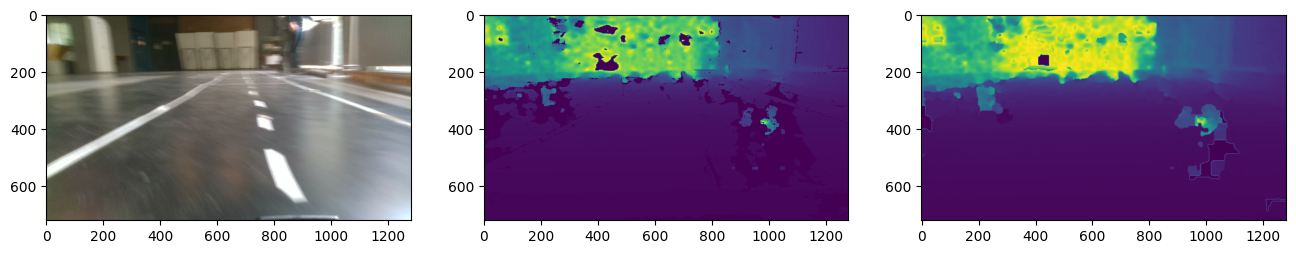

In [25]:
depth = np.asarray(rgbd_images[0].depth).copy()
filled = fill_in_fast(depth, max_depth=16, custom_kernel=DIAMOND_KERNEL_5, extrapolate=True, blur_type="gaussian")

fig, ax = plt.subplots(1, 3, figsize=(16, 12))
ax[0].imshow(rgbd_images[0].color, cmap="gray")
ax[1].imshow(rgbd_images[0].depth)
ax[2].imshow(filled);

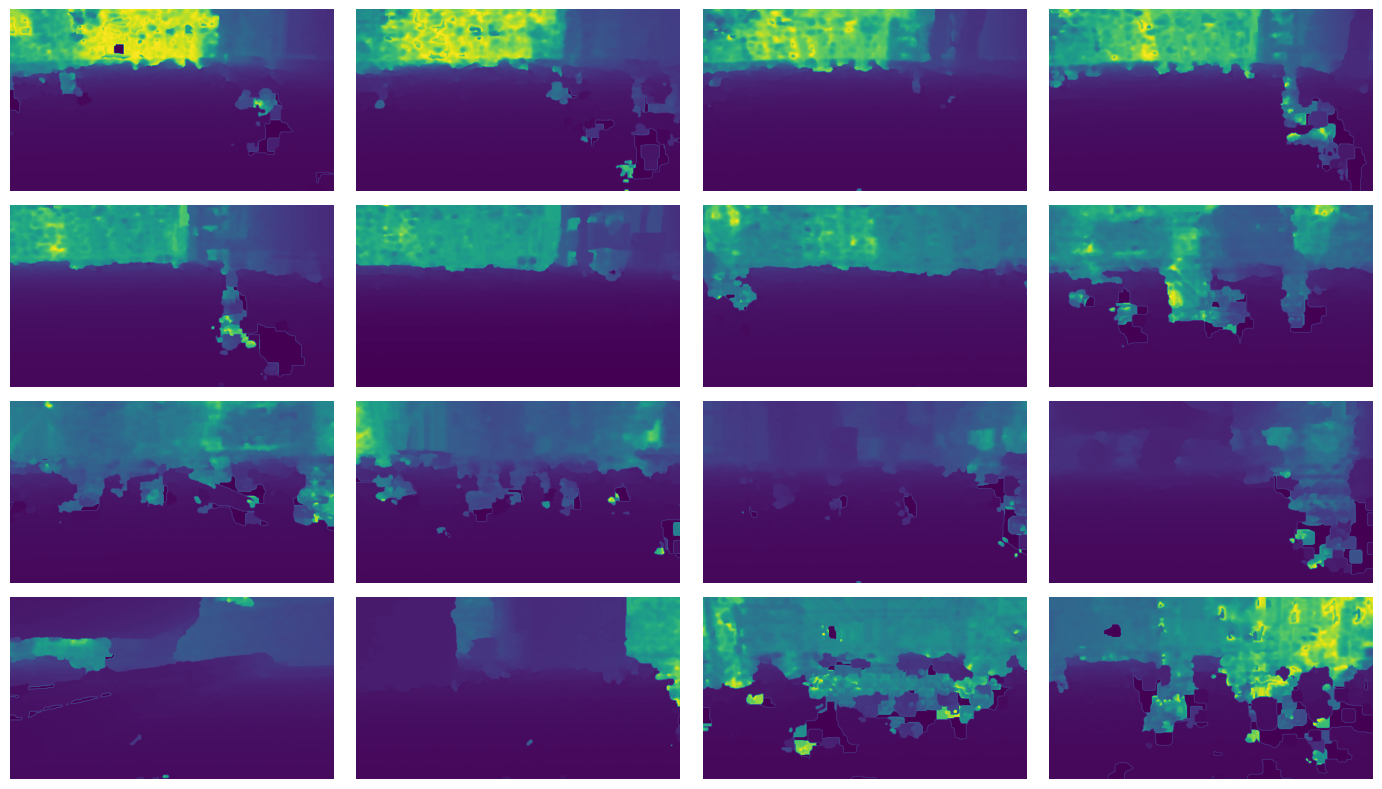

In [26]:
def apply_depth_completion(image):
    depth = np.asarray(image.depth).copy()
    return fill_in_fast(depth, max_depth=16.0, custom_kernel=DIAMOND_KERNEL_5, extrapolate=True, blur_type="gaussian")

fig = plot_image_grid(rgbd_images, image_transform=apply_depth_completion, figsize=(14, 8))
fig.tight_layout()

### BEV from Pointcloud

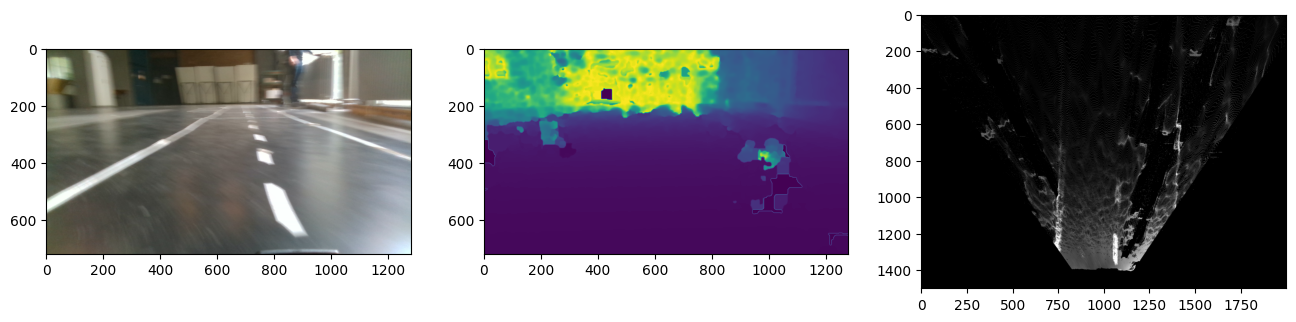

In [27]:
intrinsics = o3d.camera.PinholeCameraIntrinsic(1280, 720, fx=913.75, fy=911.92, cx=655.42, cy=350.49)
extrinsic_matrix = np.array(
    [
        [-1.0, 0.005, -0.004, -0.0],
        [0.005, 0.168, -0.986, -0.236],
        [-0.005, -0.986, -0.168, -0.062],
        [0.0, 0.0, 0.0, 1.0],
    ]
)

filled_rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
    rgbd_images[0].color, o3d.geometry.Image(filled * 1000.0)
)
point_cloud = o3d.geometry.PointCloud.create_from_rgbd_image(filled_rgbd, intrinsics, project_valid_depth_only=False)
point_cloud.transform(extrinsic_matrix)

pcd = o3d.t.geometry.PointCloud.from_legacy(point_cloud)
scale = 4.0
intrinsic = o3d.core.Tensor(np.array([[scale * 1000, 0, 1000], [0, scale * 1000, 1800], [0, 0, 1]]))
extrinsics = o3d.core.Tensor(np.array([[-1, 0, 0, 0], [0, 1, 0, 0], [0, 0, -1, 5], [0, 0, 0, 1]]))
rgbd_reproj = pcd.project_to_rgbd_image(2000, 1500, intrinsic, extrinsics, depth_scale=1000, depth_max=20.0)

fig, ax = plt.subplots(1, 3, figsize=(16, 12))
ax[0].imshow(rgbd_images[0].color, cmap="gray")
ax[1].imshow(filled)
ax[2].imshow(rgbd_reproj.color, cmap="gray")

### BEV with estimated ground plane

In [28]:
def create_plane_mesh(normal, dist, size=1):
    # rot = o3d.geometry.get_rotation_matrix_from_xyz((0, -np.pi / 2, 0))
    plane = o3d.geometry.TriangleMesh.create_box(width=size, height=size, depth=0.01)
    # plane.rotate(rot, center=(0, 0, 0))
    # plane.translate(center - normal * size / 2)
    desired_normal = np.array([0, 0, 1])
    rotation_axis = np.cross(normal, desired_normal)
    rotation_axis = rotation_axis / np.linalg.norm(rotation_axis)  # Normalize the axis

    # Compute the angle between the original normal and the desired normal
    cos_theta = np.dot(normal, desired_normal)
    angle = -np.arccos(cos_theta) + np.pi

    # Compute the rotation matrix using the rotation axis and angle
    R = o3d.geometry.get_rotation_matrix_from_axis_angle(rotation_axis * angle)

    # Rotate the box using the rotation matrix
    plane.translate(np.array([-size / 2, 0, 0.0]))
    plane.rotate(R, center=(0, 0, 0))
    plane.translate(-normal * dist)
    return plane

In [29]:
def extract_ground_plane(rgbd_image):
    intrinsics = o3d.camera.PinholeCameraIntrinsic(1280, 720, fx=913.75, fy=911.92, cx=655.42, cy=350.49)
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
        rgbd_image.color, rgbd_image.depth, depth_scale=1.0, depth_trunc=5.0, convert_rgb_to_intensity=False
    )
    # rgbd.color = rgbd_image.color
    # rgbd.depth = rgbd_image.depth
    # rgbd.depth = o3d.geometry.Image(fill_in_fast(np.asarray(rgbd.depth), max_depth=16, custom_kernel=DIAMOND_KERNEL_5, extrapolate=True, blur_type='gaussian'))
    point_cloud = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsics)

    plane_model, _ = point_cloud.segment_plane(distance_threshold=0.01, ransac_n=3, num_iterations=1000)
    plane_ransac = create_plane_mesh(normal=plane_model[:3], size=3, dist=plane_model[-1])

    # points = np.array([[0.0, 0.0, 4.0, 4.0], [-2.0, 2.0, 2.0, -2.0], [0.0, 0.0, 0.0, 0.0]])

    width = 3
    min_distance = 0.3
    max_distance = 3
    points = np.array(
        [
            [-width / 2, 0, min_distance],
            [-width / 2, 0, max_distance],
            [width / 2, 0, max_distance],
            [width / 2, 0, min_distance],
        ]
    )
    roi = o3d.geometry.PointCloud()
    roi.points = o3d.utility.Vector3dVector(points)
    roi.paint_uniform_color([1, 0, 0])

    projected = points.copy()
    projected[:, 1] = -plane_model[0] * points[:, 0] - plane_model[2] * points[:, 2] - plane_model[3]
    roi_projected = o3d.geometry.PointCloud()
    roi_projected.points = o3d.utility.Vector3dVector(projected)
    roi_projected.paint_uniform_color([0, 1, 0])

    pixels = intrinsics.intrinsic_matrix @ projected.T
    pixels = np.divide(pixels, pixels[2, :], out=pixels, where=pixels[2, :] != 0)

    scale = 250  # pixels per meter
    target_height = int((max_distance - min_distance) * scale)
    target_width = int(width * scale)

    dst_points = np.array(
        [[0, target_height], [0, 0], [target_width, 0], [target_width, target_height]], dtype=np.float32
    )

    print(f"height: {target_height}, width: {target_width}")
    print(f"target_height: {(max_distance - min_distance) * scale}, target_width: {width * scale}")

    # target_height = 2000  # pixels
    # target_width = 1500  # pixels
    # scale = 250  # pixels per meter
    center = np.array([[target_width / 2, target_height / 2]], dtype=np.float32).T

    def as_cv_coords(points):
        return points[:2].T.astype(np.float32)

    src_points = as_cv_coords(pixels)
    # dst_points = as_cv_coords(center + np.vstack([points[:, 0], points[:, 2]]) * scale)
    # dst_points = np.array([dst_points[1], dst_points[0], dst_points[3], dst_points[2]], dtype=np.float32)

    print("src (calc): ", src_points)
    print("dst (calc): ", dst_points)
    # print(dst_points)

    H = cv.getPerspectiveTransform(src=src_points, dst=dst_points)

    o3d.visualization.draw_geometries(
        [point_cloud, o3d.geometry.TriangleMesh.create_coordinate_frame(), plane_ransac, roi, roi_projected]
    )
    return H, src_points, dst_points, (target_width, target_height)

    # o3d.visualization.draw_geometries([point_cloud])
    # return plane_model


H, src_calc, dst_calc, size = extract_ground_plane(rgbd_images[0])
# extract_ground_plane(np.asarray(rgbd_images[0].color), np.asarray(rgbd_images[0].depth) * 1000)
# array([ 0.01133964,  0.98323778,  0.18197493, -0.17934185])

p0 = (28, 500)
p1 = (564, 238)
p2 = (697, 238)
p3 = (756, 500)
target_height = 2000  # pixels
target_width = 1500  # pixels
src_points = np.array([p0, p1, p2, p3], dtype=np.float32)
dst_points = np.array(
    [
        [target_width / 3, target_height - 125],
        [target_width / 3, 500],
        [target_width / 2, 500],
        [target_width / 2, target_height - 125],
    ],
    dtype=np.float32,
)

print("src (man): ", src_points)
print("dst (man): ", dst_points)

height: 675, width: 750
target_height: 675.0, target_width: 750
src (calc):  [[-3913.33      832.6019 ]
 [  198.545     249.2382 ]
 [ 1112.295     229.97903]
 [ 5224.17      640.0102 ]]
dst (calc):  [[  0. 675.]
 [  0.   0.]
 [750.   0.]
 [750. 675.]]
src (man):  [[ 28. 500.]
 [564. 238.]
 [697. 238.]
 [756. 500.]]
dst (man):  [[ 500. 1875.]
 [ 500.  500.]
 [ 750.  500.]
 [ 750. 1875.]]


In [30]:
T = np.array([[ 4.14817429e-02, -1.67794121e-01,  9.84948932e-01,  2.83688839e+00],
 [-9.99127972e-01, -2.27997881e-03,  4.16904890e-02,  5.66983852e-01],
 [-4.74975625e-03, -9.85819423e-01, -1.67742377e-01, -6.21738201e-02],
 [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [31]:
gray_image = cv.cvtColor(color_images[0].image, cv.COLOR_BGR2GRAY)
edge_image = cv.Canny(gray_image, 50, 150)

color = o3d.geometry.Image(edge_image)
depth = np.asarray(depth_images[0].image).copy()
depth[edge_image == 0] = 0
depth = o3d.geometry.Image(depth)
rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(color, depth, depth_scale=1000.0, depth_trunc=1.5)

point_cloud = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsics)
point_cloud.transform(T)
point_cloud.paint_uniform_color([0, 0, 0])

PointCloud with 4852 points.

In [32]:
o3d.visualization.draw_geometries([point_cloud, o3d.geometry.TriangleMesh.create_coordinate_frame()])

In [33]:
import pandas as pd

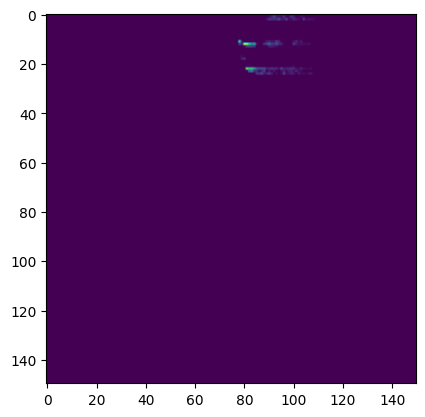

In [34]:
resolution = 25 # pixel per meter

points = np.asarray(point_cloud.points)
df = pd.DataFrame(points, columns=['x', 'y', 'z'])
df = df[(df['x'] > 0.0) & (df['x'] < 15.0 ) & (df['y'] > 0) & (df['y'] < 15)]

df['x_index'] = ((df['x']) * resolution).astype(int)
df['y_index'] = ((df['y']) * resolution).astype(int)

grid_counts = df.groupby(['y_index', 'x_index']).size().reset_index(name='count')

img = np.zeros((150, 150), dtype=np.uint8)
img[grid_counts["y_index"].values, grid_counts["x_index"].values] = grid_counts["count"].values

plt.imshow(img)

# grid_counts["x_index"].values.min()

In [35]:
df.describe()

x            y            z      x_index      y_index
count  4802.000000  4802.000000  4802.000000  4802.000000  4802.000000
mean      3.533543     0.611199    -0.232280    87.833195    14.847147
std       0.306363     0.292594     0.012941     7.657332     7.313918
min       3.126124     0.015945    -0.249622    78.000000     0.000000
25%       3.279698     0.482963    -0.238001    81.000000    12.000000
50%       3.422583     0.517391    -0.235612    85.000000    12.000000
75%       3.751557     0.899024    -0.229703    93.000000    22.000000
max       4.351111     0.993082    -0.127799   108.000000    24.000000

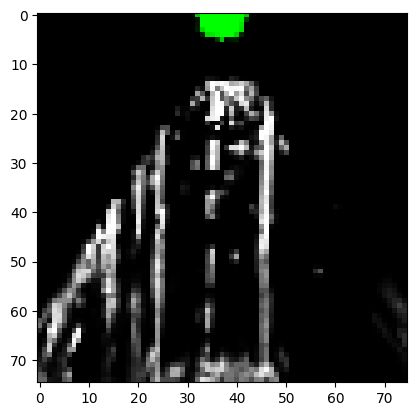

In [36]:
img = cv.imread("/home/josua/kal2_ws/src/kal2_perception/notebooks/debug_bev-0-0.png")
plt.imshow(img)

0 700
591 6608
5003 6624
5383 4518
3471 3262
2777 2066
4815 5529


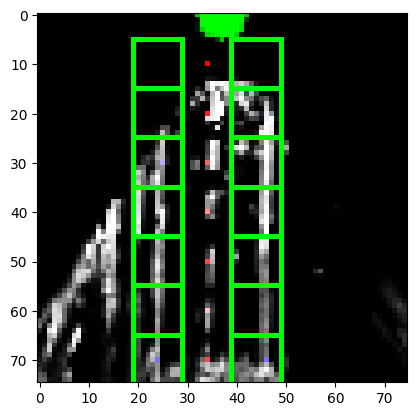

In [37]:
img = cv.imread("/home/josua/kal2_ws/src/kal2_perception/notebooks/debug_bev-0-0.png")

x_0 = 34
x = np.ones((8,), dtype=int) * x_0

lane_width = 10
window_width = 5
window_height = 5

for i in range(1, 8):
    y = i * 10
    img[y, x_0, 0] = 255

    x_left = x[i] - lane_width
    x_right = x[i] + lane_width
    img = cv.rectangle(img, (x_left - window_width, y - 5), (x_left + window_width, y + 5), (0, 255, 0), 1)
    img = cv.rectangle(img, (x_right - window_width, y - 5), (x_right + window_width, y + 5), (0, 255, 0), 1)

    left_sum = img[y-5:y+5, x_left-window_width:x_left+window_width, 0].sum(axis=0)
    right_sum = img[y-5:y+5, x_right-window_width:x_right+window_width, 0].sum(axis=0)

    max_left = np.argmax(left_sum) + x_left - window_width
    max_right = np.argmax(right_sum) + x_right - window_width

    def is_valid(sum):
        return sum.sum() > window_height * 3 * 255
    
    left_valid = is_valid(left_sum)
    right_valid = is_valid(right_sum)

    if left_valid:
        img[y, max_left, 2] = 255

    if right_valid:
        img[y, max_right, 2] = 255 

    if left_valid and right_valid:
        x[i] = (max_left + max_right) // 2
    elif left_valid:
        x[i] = max_left
    elif right_valid:
        x[i] = max_right

    print(left_sum.sum(), right_sum.sum())

plt.imshow(img)

In [83]:
selected_images = color_images[[0, 3, 7, 14]]

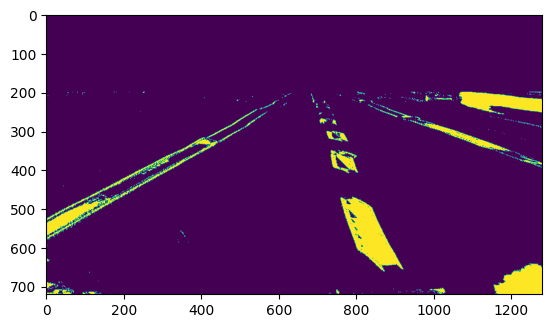

In [39]:
def hsl_algo(color_image):
    cv2 = cv

    gray_ex = cv2.cvtColor(color_image, cv2.COLOR_RGB2GRAY)
    # display(gray_ex, "Apply Camera Correction", color=0)


    def directional_gradient(img, direction="x", thresh=[0, 255]):
        """
        img:Grayscale
        direction:x or y axis
        thresh:apply threshold on pixel intensity of gradient image
        output is binary image
        """
        if direction == "x":
            sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
        elif direction == "y":
            sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
        sobel_abs = np.absolute(sobel)
        scaled_sobel = np.uint8(sobel_abs * 255 / np.max(sobel_abs))
        binary_output = np.zeros_like(sobel)
        binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
        return binary_output


    gradx_thresh = [25, 255]
    gradx = directional_gradient(gray_ex, direction="x", thresh=gradx_thresh)
    # display(gradx, "Gradient x", color=0)


    def color_binary(img, dst_format="HLS", ch=2, ch_thresh=[0, 255]):
        """
        Color thresholding on channel ch
        img:RGB
        dst_format:destination format(HLS or HSV)
        ch_thresh:pixel intensity threshold on channel ch
        output is binary image
        """
        if dst_format == "HSV":
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            ch_binary = np.zeros_like(img[:, :, int(ch - 1)])
            ch_binary[(img[:, :, int(ch - 1)] >= ch_thresh[0]) & (img[:, :, int(ch - 1)] <= ch_thresh[1])] = 1
        else:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            ch_binary = np.zeros_like(img[:, :, int(ch - 1)])
            ch_binary[(img[:, :, int(ch - 1)] >= ch_thresh[0]) & (img[:, :, int(ch - 1)] <= ch_thresh[1])] = 1
        return ch_binary


    ch_thresh = [50, 255]
    ch3_hls_binary = color_binary(color_image, dst_format="HLS", ch=3, ch_thresh=ch_thresh)
    # display(ch3_hls_binary, "HLS to Binary S", color=0)

    combined_output = np.zeros_like(gradx)
    combined_output[((gradx == 1) | (ch3_hls_binary == 1))] = 1
    # display(combined_output, "Combined output", color=0)

    mask = np.zeros_like(combined_output)
    # mask[mask.shape[0] // 2 :, :] = 1
    mask[200:, :] = 1
    masked_image = cv2.bitwise_and(combined_output, mask)
    # display(masked_image, "Masked", color=0)

    return masked_image

def apply_hsl_algo(image):
    img =  hsl_algo(image)
    return bev_transformer.transform(img)

img = hsl_algo(color_images[0].image)
plt.imshow(img)

In [40]:
from onnxruntime import InferenceSession
session = InferenceSession("/mnt/c/Users/Josua/Documents/Studium/simple_segmentation_model_v2.onnx")

In [41]:
def apply_segmentation_nn(color_image, bev=True):
    horizon = 200 # px
        
    img = np.array([cv.resize(color_image[horizon:], (224, 224), interpolation=cv.INTER_CUBIC)]).astype(np.float32) / 255.0
    segmented_image = session.run(None, {"input_1": img})

    segmented_image = segmented_image[0].squeeze()
    segmented_image = cv.resize(segmented_image, (color_image.shape[1], color_image.shape[0]-horizon), interpolation=cv.INTER_LINEAR)
    segmented_image = (segmented_image * 255).astype(np.uint8)

    segmented_image_reshaped = np.zeros((720, 1280), dtype=np.uint8)
    segmented_image_reshaped[horizon:] = segmented_image

    if bev:
        return bev_transformer.transform(segmented_image_reshaped)
    return segmented_image_reshaped

In [59]:
extrinsic_matrix = np.array(
    [
        [-0.00471339, -0.99997761, -0.00474976, 0.00151022],
        [-0.16772034, 0.00547306, -0.98581942, 0.158225],
        [0.98582335, -0.00384992, -0.16774238, -0.21260152],
        [0.0, 0.0, 0.0, 1.0],
    ]
)

intrinsic_matrix = np.array([[913.75, 0.0, 655.42], [0.0, 911.92, 350.49], [0.0, 0.0, 1.0]])

bev_transformer = BevTransformer.from_roi(
        roi=BevRoi(0.5, 1.5, 1.5), intrinsic_matrix=intrinsic_matrix, extrinsic_matrix=extrinsic_matrix, scale=240
    )

In [60]:
plt.rcParams.update({'font.size': 18})

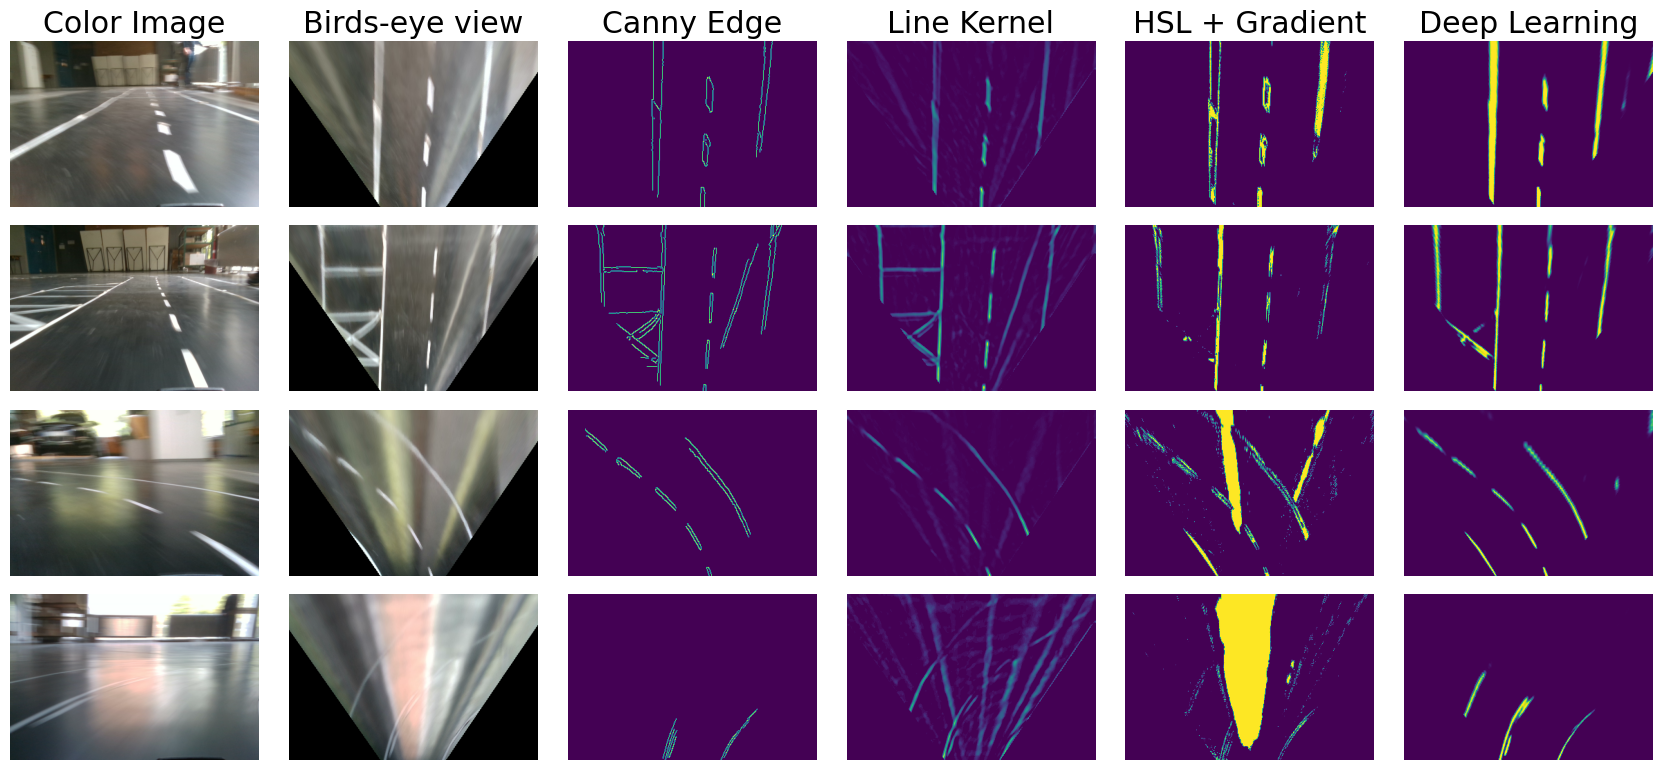

In [61]:
fig, ax = plt.subplots(4, 6, figsize=(17, 8))

for i, image in enumerate(selected_images):
    ax[i, 0].imshow(image.image[:, 100:-100])
    ax[i, 0].axis("off")

    bev = apply_bev_transform(image.image)
    ax[i, 1].imshow(bev)
    ax[i, 1].axis("off")

    canny = apply_canny_edge_detection(image.image)
    cv.line(canny, (0, 50), (475, 720), 0, 5)
    cv.line(canny, (360, 45), (-100, 720), 0, 5)
    canny = (canny - canny.min()) / (canny.max() - canny.min())
    ax[i, 2].imshow(canny)
    ax[i, 2].axis("off")

    custom = apply_custom_kernel(image.image)
    cv.line(custom, (0, 50), (475, 720), 0, 10)
    cv.line(custom, (360, 45), (-100, 720), 0, 10)
    custom = (custom - custom.min()) / (custom.max() - custom.min())
    ax[i, 3].imshow(custom)
    ax[i, 3].axis("off")

    hsl = apply_hsl_algo(image.image)
    hsl = (hsl - hsl.min()) / (hsl.max() - hsl.min())
    ax[i, 4].imshow(hsl)
    ax[i, 4].axis("off")

    nn = apply_segmentation_nn(image.image)
    nn = (nn - nn.min()) / (nn.max() - nn.min())
    ax[i, 5].imshow(nn)
    ax[i, 5].axis("off")

ax[0, 0].set_title("Color Image")
ax[0, 1].set_title("Birds-eye view")
ax[0, 2].set_title("Canny Edge")
ax[0, 3].set_title("Line Kernel")
ax[0, 4].set_title("HSL + Gradient")
ax[0, 5].set_title("Deep Learning")

fig.tight_layout()

In [63]:
def plot_histogram_peaks(image, ax):
        from scipy.signal import find_peaks
        
        nn = apply_segmentation_nn(image, bev=True) / 255.0
        nn = (nn - nn.min()) / (nn.max() - nn.min())

        for row in range(nn.shape[0]):
            peaks, _ = find_peaks(nn[row, :])
            ax.scatter(peaks[::2], np.ones_like(peaks)[::2] * row, marker="x", color="red")

        return fig

In [64]:
def plot_lines(lines, ax, plot_normals=False):
    if lines is None:
        return

    for line in lines:
            x1, y1, x2, y2 = line[0]

            normal = np.array([y2 - y1, x1 - x2])
            normal =10 * (normal / np.linalg.norm(normal))
            center = np.array([(x1 + x2) / 2, (y1 + y2) / 2])

            ax.plot([x1, x2], [y1, y2], linewidth=2)

            if plot_normals:
                ax.plot([center[0], center[0] + normal[0]], [center[1], center[1] + normal[1]], color='blue', linewidth=2)

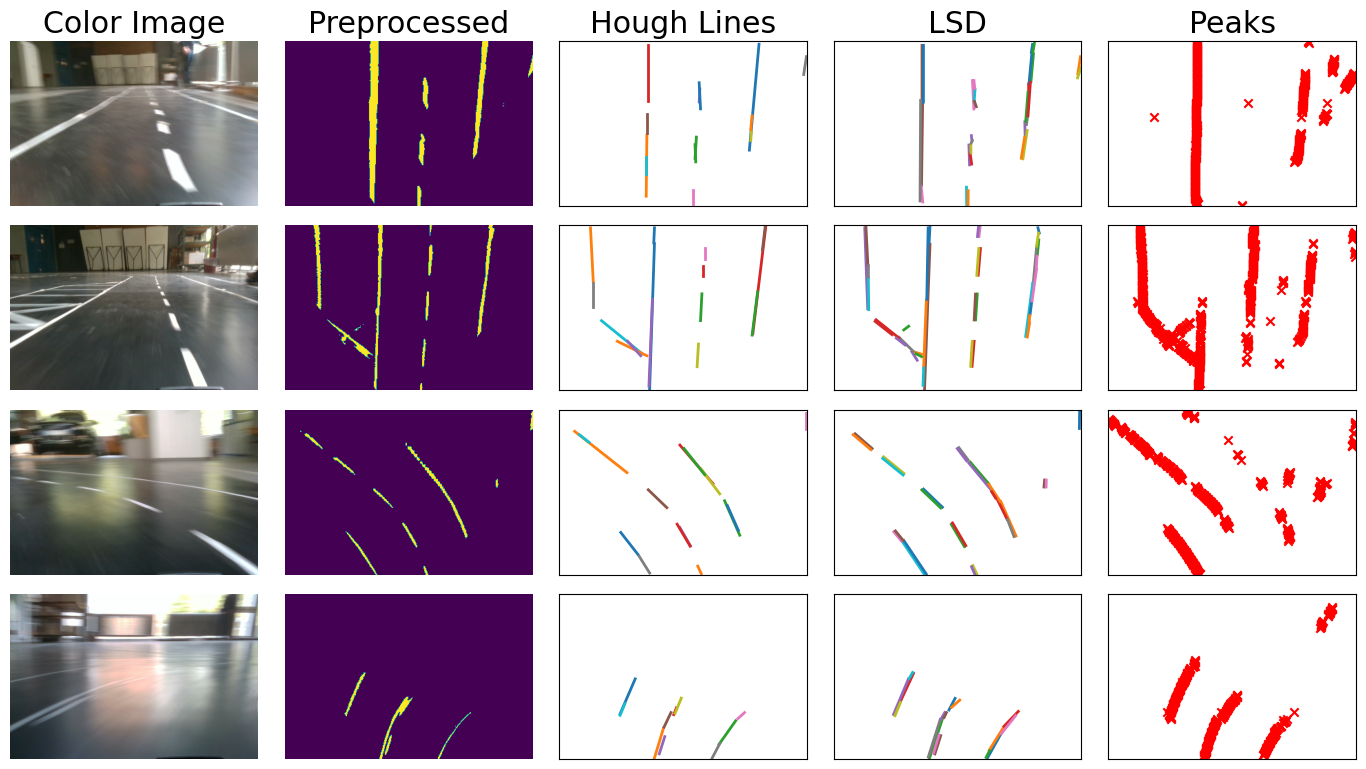

In [65]:
fig, ax = plt.subplots(4, 5, figsize=(14, 8))

for i, image in enumerate(selected_images):
    ax[i, 0].imshow(image.image[:, 100:-100])
    ax[i, 0].axis("off")

    # bev = apply_bev_transform(image.image)

    nn = apply_segmentation_nn(image.image)
    nn = cv.normalize(nn, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    nn = cv.threshold(nn, 127, 255, cv.THRESH_BINARY)[1]

    ax[i, 1].imshow(nn)
    ax[i, 1].axis("off")

    from skimage.morphology import skeletonize
    skeleton = skeletonize(nn).astype(np.uint8) * 255
    lines = cv.HoughLinesP(skeleton, 1, np.pi / 180, 10, minLineLength=10, maxLineGap=20)

    hough_image = cv.cvtColor(skeleton, cv.COLOR_GRAY2BGR)
    plot_lines(lines, ax[i, 2], plot_normals=False)
    ax[i, 2].imshow(np.ones_like(hough_image) * 255, cmap="gray")
    ax[i, 2].set_xticks([])
    ax[i, 2].set_yticks([])

    lsd_image = skeleton.copy()
    lsd = cv.createLineSegmentDetector()
    lines, _, _, _ = lsd.detect(lsd_image)
    lsd_image = lsd.drawSegments(lsd_image, lines)

    plot_lines(lines, ax[i, 3], plot_normals=False)
    ax[i, 3].imshow(np.ones_like(lsd_image) * 255, cmap="gray")
    ax[i, 3].set_xticks([])
    ax[i, 3].set_yticks([])

    plot_histogram_peaks(image.image, ax[i, 4])
    ax[i, 4].imshow(np.ones_like(lsd_image) * 255, cmap="gray")
    ax[i, 4].set_xticks([])
    ax[i, 4].set_yticks([])


ax[0, 0].set_title("Color Image")
ax[0, 1].set_title("Preprocessed")
ax[0, 2].set_title("Hough Lines")
ax[0, 3].set_title("LSD")
ax[0, 4].set_title("Peaks")
# ax[0, 4].set_title("HSL + Gradient")
# ax[0, 5].set_title("Deep Learning")

fig.tight_layout()

(55816, 3)


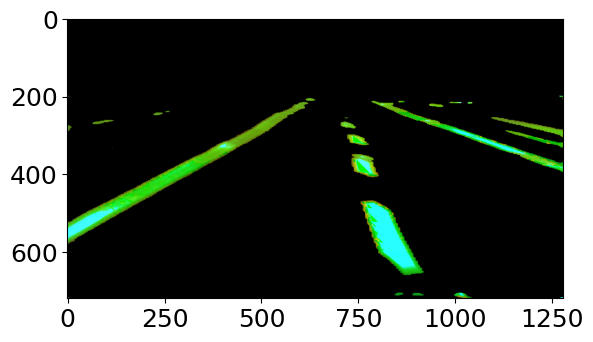

In [66]:
hsl = cv.cvtColor(selected_images[0].image, cv.COLOR_BGR2HLS)
as_points = np.array([hsl[:, :, 0].flatten(), hsl[:, :, 1].flatten(), hsl[:, :, 2].flatten()]).T[::50]

nn = apply_segmentation_nn(selected_images[0].image, bev=False)
nn[nn > 0] = 255

lane_pixels = np.argwhere(nn == 255)
hsl_lane = hsl[lane_pixels[:, 0], lane_pixels[:, 1]]
as_points_lane = np.array([hsl_lane[:, 0], hsl_lane[:, 1], hsl_lane[:, 2]]).T[::50]

hsl_lane_image = np.zeros((720, 1280, 3), dtype=np.uint8)
hsl_lane_image[lane_pixels[:, 0], lane_pixels[:, 1]] = hsl_lane
plt.imshow(hsl_lane_image)

print(hsl_lane.shape)

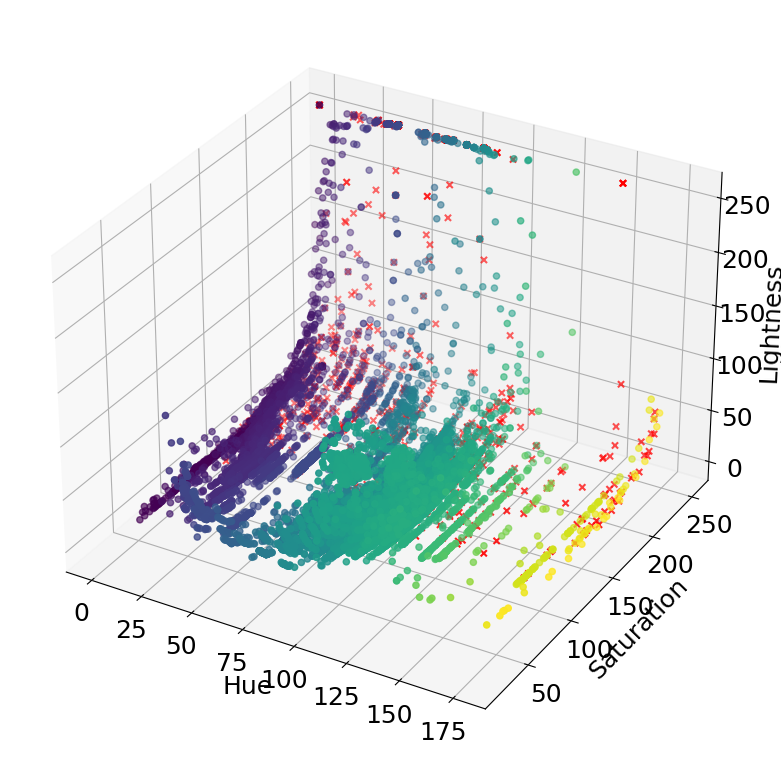

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8), subplot_kw={'projection': '3d'})

ax.scatter(as_points[:, 0], as_points[:, 1], as_points[:, 2], c=as_points[:, 0], cmap='viridis')
ax.scatter(as_points_lane[:, 0], as_points_lane[:, 1], as_points_lane[:, 2], color="red", marker="x")
ax.set_xlabel('Hue')
ax.set_ylabel('Saturation')
ax.set_zlabel('Lightness')

fig.tight_layout()

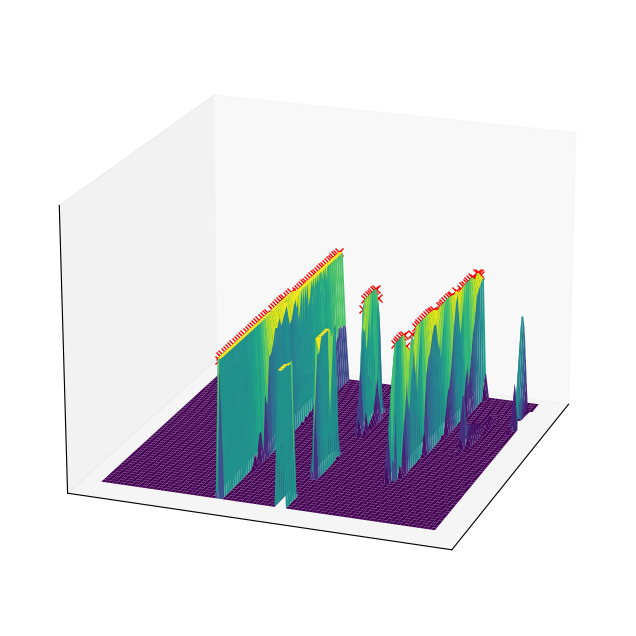

In [68]:
def plot_histogram_peaks(image):
        nn = apply_segmentation_nn(image, bev=True)[::4, ::4] / 255.0
        # nn = cv.GaussianBlur(nn, (3, 3), 0)

        xx, yy = np.mgrid[0 : nn.shape[0], 0 : nn.shape[1]]

        fig, ax = plt.subplots(1, 1, figsize=(14, 8), subplot_kw={"projection": "3d"})
        ax.plot_surface(xx, yy, nn, rstride=1, cstride=1, cmap="viridis", linewidth=0)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.view_init(20, 20)
        ax.set_zlim(0.0, 2)

        from scipy.signal import find_peaks

        for row in range(nn.shape[0]):
            peaks, _ = find_peaks(nn[row, :], height=0.8)
            ax.plot(np.ones_like(peaks) * row, peaks, nn[row, peaks], "x", color="red")

        return fig

fig = plot_histogram_peaks(selected_images[0].image)

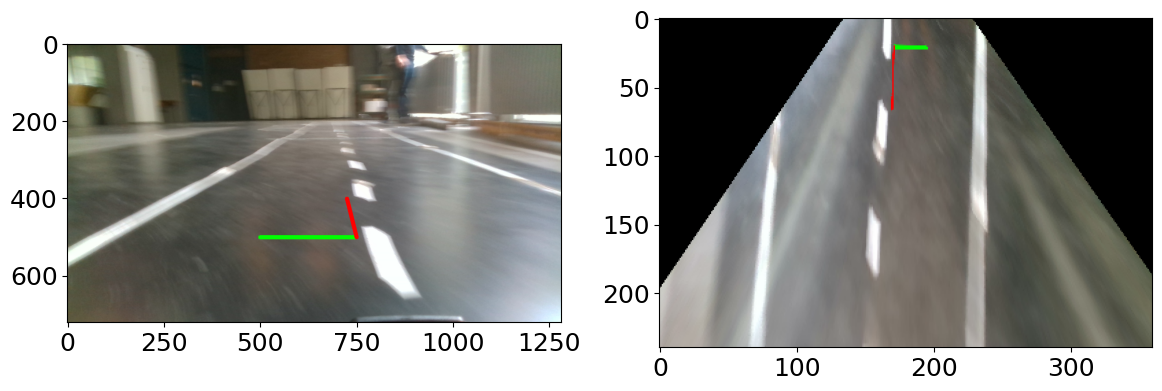

In [95]:
tf = bev_transformer.from_roi(BevRoi(0.5, 1.5, 1.5), intrinsic_matrix, extrinsic_matrix, scale=240)

img = selected_images[0].image.copy()
x0 = 750
y0 = 500
cv.line(img, (x0, y0), (500, y0), (0, 255, 0), 10)
cv.line(img, (x0, y0), (725, y0-100), (255, 0, 0), 10)
bev = tf.transform(img)

fig, ax = plt.subplots(1, 2, figsize=(14, 8))
ax[0].imshow(img)
ax[1].imshow(bev)